In [1]:
import pvlib

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import scipy
from scipy.io import loadmat

The Polydome experiments have been done in the following order, begining and end dates:

| No | Start Date       | End Date         |
|----|------------------|------------------|
| 1  | 01.06.2017 20:00 | 03.06.2017 17:00 |
| 2  | 10.06.2017 16:00 | 12.06.2017 06:00 |
| 3  | 16.06.2017 20:00 | 19.06.2017 06:00 |
| 4  | 19.06.2017 20:00 | 22.06.2017 06:00 |
| 5  | 30.06.2017 20:00 | 03.07.2017 06:00 |
| 6  | 07.07.2017 20:00 | 10.07.2017 06:00 |
| 7  | 13.07.2017 20:00 | 20.07.2017 06:00 |
| 8  | 21.07.2017 20:00 | 24.07.2017 06:00 |

Load the experimental data pertaining to the first experiment:

In [5]:
mat_exp1 = loadmat('../Data/Luca_experimental_data/Exp1.mat')
measured_vals = [*mat_exp1['Exp1'].dtype.fields]
measured_vals

['Power',
 'Setpoint',
 'OutsideTemp',
 'SupplyTemp',
 'InsideTemp',
 'LakeTemp',
 'SolRad',
 'SolRad_DA']

In [6]:
def df_from_mb_struct(mb_mat, field):
    df_field = pd.DataFrame({
            'timestamp': pd.Series(np.array(mb_mat[field][0,0]['time'][0,0]).flatten()),
            'value': pd.Series(np.array(mb_mat[field][0,0]['values'][0,0]).flatten())
            })
    df_field['timestamp'] = pd.to_datetime(df_field['timestamp'], unit = 's', utc = False) + pd.Timedelta(2, 'hours')
    df_field['timestamp'] = pd.DatetimeIndex(df_field['timestamp'], tz = 'Europe/Zurich')
    df_field.set_index('timestamp', inplace = True, drop = True)
    df_field.columns = [field]
    
    return df_field

In [7]:
dict_dfs = {}
for var in measured_vals:
    dict_dfs[var] = df_from_mb_struct(mat_exp1['Exp1'], var)

In [8]:
df = dict_dfs[measured_vals[0]]

for idx in range(1, len(measured_vals)):
    df = pd.concat([df, dict_dfs[measured_vals[idx]]], axis = 1)
df

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,LakeTemp,SolRad,SolRad_DA
timestamp,,,,,,,,
2017-06-01 20:00:00+02:00,5995.034483,23.5,22.0,24.5,24.4,24.200000,61.321333,122.0
2017-06-01 20:05:00+02:00,5957.000000,23.5,22.0,15.5,24.4,24.166667,57.926100,91.5
2017-06-01 20:10:00+02:00,5989.766667,23.5,22.0,15.2,24.1,24.066667,54.902033,91.5
2017-06-01 20:15:00+02:00,4563.344828,23.5,22.0,14.9,23.8,24.066667,73.860700,91.5
2017-06-01 20:20:00+02:00,1729.137931,23.5,22.0,18.2,23.5,23.833333,76.042533,91.5
...,...,...,...,...,...,...,...,...
2017-06-03 16:35:00+02:00,1732.137931,24.5,24.0,16.4,22.3,22.300000,361.247267,570.0
2017-06-03 16:40:00+02:00,1727.482759,24.5,24.0,17.6,22.3,22.300000,596.456167,570.0
2017-06-03 16:45:00+02:00,1726.233333,24.5,24.0,18.5,22.3,22.333333,550.335400,570.0


In [9]:
df['Power'] = df['Power'] - 1.67 * 1000 # remove the fan power consumption
df['Power'] = np.where(df['Power'] > 6300, 6300, df['Power']) # cap to 1 compressor to remove non-linear effects

Take the inside temperature to be the average of the two sensors (`InsideTemp` and `LakeTemp`):

In [10]:
df['InsideTemp'] = df[['LakeTemp', 'InsideTemp']].mean(axis = 1) # Averaged Inside Temperature

In [11]:
df.drop(columns = ['LakeTemp', 'SolRad_DA'], inplace = True) # Drop GHI prediction and the non-averaged inside temp measure
df

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad
timestamp,,,,,,
2017-06-01 20:00:00+02:00,4325.034483,23.5,22.0,24.5,24.300000,61.321333
2017-06-01 20:05:00+02:00,4287.000000,23.5,22.0,15.5,24.283333,57.926100
2017-06-01 20:10:00+02:00,4319.766667,23.5,22.0,15.2,24.083333,54.902033
2017-06-01 20:15:00+02:00,2893.344828,23.5,22.0,14.9,23.933333,73.860700
2017-06-01 20:20:00+02:00,59.137931,23.5,22.0,18.2,23.666667,76.042533
...,...,...,...,...,...,...
2017-06-03 16:35:00+02:00,62.137931,24.5,24.0,16.4,22.300000,361.247267
2017-06-03 16:40:00+02:00,57.482759,24.5,24.0,17.6,22.300000,596.456167
2017-06-03 16:45:00+02:00,56.233333,24.5,24.0,18.5,22.316667,550.335400


### Solar angles

Get altitude information for Polydome GPS coordinates:

<img src="Images/polydome_altitude.png" alt="Polydome Altitude Source" width="500"/>

In [12]:
latitude = 46.521476
longitude = 6.569009
altitude = 395

Compute the solar position from GPS/altitude data:

<img src="Images/solar_angles.png" alt="Diagram of the zenith/azimuth angles definition" width="500"/>

In [13]:
df_solarposition = pvlib.solarposition.get_solarposition(
    time = df.index,
    latitude = latitude, 
    longitude = longitude,
    temperature = df['OutsideTemp'],
    altitude = altitude
)
df_solarposition

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
timestamp,,,,,,
2017-06-01 20:00:00+02:00,78.691622,78.765922,11.308378,11.234078,290.430819,2.098613
2017-06-01 20:05:00+02:00,79.489651,79.569259,10.510349,10.430741,291.279501,2.098069
2017-06-01 20:10:00+02:00,80.282334,80.367965,9.717666,9.632035,292.130503,2.097524
2017-06-01 20:15:00+02:00,81.069332,81.161848,8.930668,8.838152,292.984123,2.096979
2017-06-01 20:20:00+02:00,81.850261,81.950719,8.149739,8.049281,293.840653,2.096433
...,...,...,...,...,...,...
2017-06-03 16:35:00+02:00,43.923091,43.937926,46.076909,46.062074,252.722275,1.796947
2017-06-03 16:40:00+02:00,44.746130,44.761396,45.253870,45.238604,253.882437,1.796365
2017-06-03 16:45:00+02:00,45.573942,45.589654,44.426058,44.410346,255.018953,1.795782


Check the difference between the real/geometrical zenith and the apparent zenith:

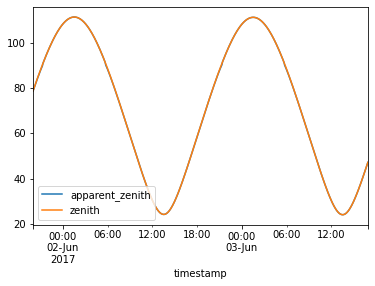

In [14]:
df_solarposition[['apparent_zenith', 'zenith']].plot()
plt.show()

Compute the angle of incidence of the sun on the surface: 

<img src="Images/angle_of_incidence.jpg" alt="Angle of incidence" width="500"/>

In [15]:
surface_tilt = 0
surface_azimuth = 0

In [16]:
df_aoi = pvlib.irradiance.aoi(
    surface_tilt = surface_tilt,
    surface_azimuth = surface_azimuth,
    solar_zenith = df_solarposition['apparent_zenith'],
    solar_azimuth = df_solarposition['azimuth']
)
df_aoi

timestamp
2017-06-01 20:00:00+02:00    78.691622
2017-06-01 20:05:00+02:00    79.489651
2017-06-01 20:10:00+02:00    80.282334
2017-06-01 20:15:00+02:00    81.069332
2017-06-01 20:20:00+02:00    81.850261
                               ...    
2017-06-03 16:35:00+02:00    43.923091
2017-06-03 16:40:00+02:00    44.746130
2017-06-03 16:45:00+02:00    45.573942
2017-06-03 16:50:00+02:00    46.406107
2017-06-03 16:55:00+02:00    47.242228
Name: aoi, Length: 540, dtype: float64

### Solar radiation

In [17]:
df_erbs = pvlib.irradiance.erbs(
    ghi = df['SolRad'],
    zenith = df_solarposition['zenith'],
    datetime_or_doy = df.index
)
df_erbs.head()

,dni,dhi,kt
timestamp,,,
2017-06-01 20:00:00+02:00,7.251337,59.908644,0.237114
2017-06-01 20:05:00+02:00,7.672114,56.537088,0.241022
2017-06-01 20:10:00+02:00,8.423139,53.492674,0.247180
2017-06-01 20:15:00+02:00,52.657244,65.770239,0.362136
2017-06-01 20:20:00+02:00,94.364403,62.829177,0.409096


In [18]:
erbs_ghi = df_erbs['dhi'] + df_erbs['dni']*np.cos(np.radians(df_solarposition['zenith']))

Compare `erbs_ghi` with measured ghi to confirm they are the same:

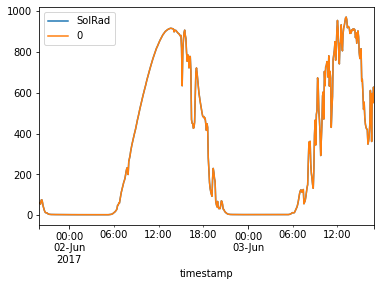

In [19]:
pd.concat([df['SolRad'], erbs_ghi], axis = 1).plot()
plt.show()

Compute the in-plane irradiance components:

In [20]:
#poa_sky_diffuse
df_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
    surface_tilt = surface_tilt,
    surface_azimuth = surface_azimuth,
    solar_zenith = df_solarposition['apparent_zenith'],
    solar_azimuth = df_solarposition['azimuth'],
    dni = df_erbs['dni'],
    ghi = df['SolRad'],
    dhi = df_erbs['dhi'],
)
df_sky_diffuse

timestamp
2017-06-01 20:00:00+02:00     59.908644
2017-06-01 20:05:00+02:00     56.537088
2017-06-01 20:10:00+02:00     53.492674
2017-06-01 20:15:00+02:00     65.770239
2017-06-01 20:20:00+02:00     62.829177
                                ...    
2017-06-03 16:35:00+02:00    314.462614
2017-06-03 16:40:00+02:00    219.485890
2017-06-03 16:45:00+02:00    250.653973
2017-06-03 16:50:00+02:00    167.328816
2017-06-03 16:55:00+02:00    215.275641
Name: dhi, Length: 540, dtype: float64

In [21]:
#poa_ground_diffuse
df_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
    surface_tilt = surface_tilt,
    ghi = df['SolRad'],
    surface_type = 'urban' # used for gound_diffuse calculation
)
df_ground_diffuse

timestamp
2017-06-01 20:00:00+02:00    0.0
2017-06-01 20:05:00+02:00    0.0
2017-06-01 20:10:00+02:00    0.0
2017-06-01 20:15:00+02:00    0.0
2017-06-01 20:20:00+02:00    0.0
                            ... 
2017-06-03 16:35:00+02:00    0.0
2017-06-03 16:40:00+02:00    0.0
2017-06-03 16:45:00+02:00    0.0
2017-06-03 16:50:00+02:00    0.0
2017-06-03 16:55:00+02:00    0.0
Name: diffuse_ground, Length: 540, dtype: float64

In [22]:
df_poa_components = pvlib.irradiance.poa_components(
    aoi = df_aoi,
    dni = df_erbs['dni'],
    poa_sky_diffuse = df_sky_diffuse,
    poa_ground_diffuse = df_ground_diffuse
)
df_poa_components

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
timestamp,,,,,
2017-06-01 20:00:00+02:00,61.330555,1.421911,59.908644,59.908644,0.0
2017-06-01 20:05:00+02:00,57.936582,1.399494,56.537088,56.537088,0.0
2017-06-01 20:10:00+02:00,54.914443,1.421769,53.492674,53.492674,0.0
2017-06-01 20:15:00+02:00,73.944706,8.174467,65.770239,65.770239,0.0
2017-06-01 20:20:00+02:00,76.206334,13.377157,62.829177,62.829177,0.0
...,...,...,...,...,...
2017-06-03 16:35:00+02:00,361.258938,46.796324,314.462614,314.462614,0.0
2017-06-03 16:40:00+02:00,596.555761,377.069871,219.485890,219.485890,0.0
2017-06-03 16:45:00+02:00,550.419278,299.765305,250.653973,250.653973,0.0


In [23]:
df['SolRad']

timestamp
2017-06-01 20:00:00+02:00     61.321333
2017-06-01 20:05:00+02:00     57.926100
2017-06-01 20:10:00+02:00     54.902033
2017-06-01 20:15:00+02:00     73.860700
2017-06-01 20:20:00+02:00     76.042533
                                ...    
2017-06-03 16:35:00+02:00    361.247267
2017-06-03 16:40:00+02:00    596.456167
2017-06-03 16:45:00+02:00    550.335400
2017-06-03 16:50:00+02:00    627.393133
2017-06-03 16:55:00+02:00    564.347267
Name: SolRad, Length: 540, dtype: float64

In [24]:
print(df_sky_diffuse.equals(df_poa_components['poa_sky_diffuse']))
print(df_ground_diffuse.equals(df_poa_components['poa_ground_diffuse']))

True
True


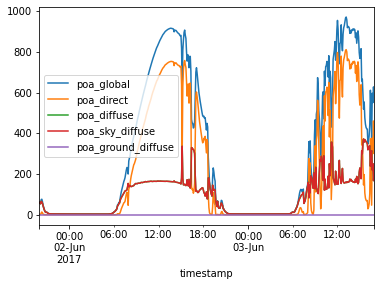

In [25]:
df_poa_components.plot()
plt.show()

### Compile the WDB vector

In [26]:
df_wdb = df.copy()
df_wdb['time'] = (df_wdb.index - df_wdb.index[0]).total_seconds()

Add the solar angles:

In [27]:
df_wdb['zenith'] = df_solarposition['apparent_zenith'] # apparent_zenith takes into account refraction due to atmosphere
df_wdb['azimuth'] = df_solarposition['azimuth']
df_wdb['aoi'] = df_aoi

Add the estimated radiation values:

In [28]:
df_wdb['dni'] = df_erbs['dni']
df_wdb['dhi'] = df_erbs['dhi']

In [29]:
df_wdb['poa_direct'] = df_poa_components['poa_direct']
df_wdb['poa_diffuse'] = df_poa_components['poa_diffuse']

In [30]:
# Radiative temperature of the sky
df_wdb['Tsky_rad'] = df_wdb['OutsideTemp'] - 6 # from email with Manuel

df_wdb['relative_humidity'] = 50 # relative humidity. placeholder
df_wdb['precipitation'] = -9999 # placeholder
df_wdb['cloud_index'] = 0.5 # from email with Manuel, for the moment assumed to not be used by the model
df_wdb['pressure'] = 96300 # placeholder, taken as mean of PUY station over the last year

df_wdb['wind_speed'] = 0 # placeholder value
df_wdb['wind_direction'] = -9999 # placeholder value

df_wdb['incidence_main'] = -9999 # also missing in sample dataset
df_wdb['incidence_second'] = -9999 # also missing in sample dataset

Change the timestamp from being an index, to being a regular column:

In [31]:
df_wdb.reset_index(inplace = True)

Transform it to the YYYYmmddHHMM format expected by Carnot WDB:

In [32]:
df_wdb['timestamp'] = df_wdb['timestamp'].dt.strftime("%Y%m%d%H%M").astype('int')

In [33]:
df_wdb['time'] = df_wdb['time'].astype('int')

In [34]:
df_wdb = df_wdb[['time', 'timestamp', 'zenith', 'azimuth', 'dni', 'dhi', 'OutsideTemp', 'Tsky_rad', 'relative_humidity', 'precipitation', 'cloud_index', 'pressure', 'wind_speed', 'wind_direction', 'aoi', 'incidence_main', 'incidence_second', 'poa_direct', 'poa_diffuse']]

Export file to matlab matrix:

In [35]:
scipy.io.savemat("../Data/Exp1_WDB.mat", {'Exp1_WDB': df_wdb.to_numpy()})

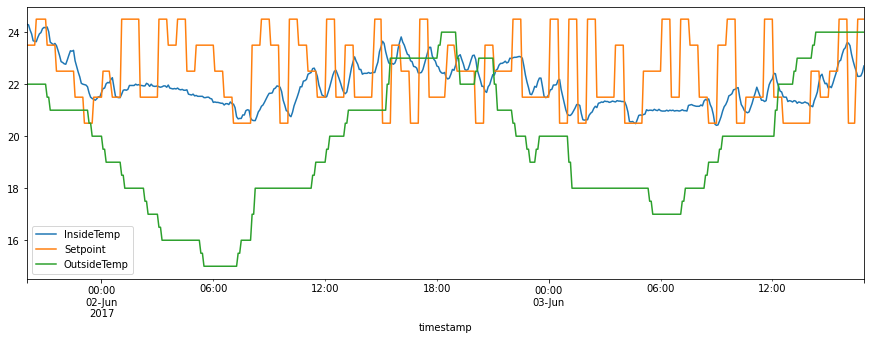

In [36]:
df[['InsideTemp', 'Setpoint', 'OutsideTemp']].plot(figsize = (15, 5))
plt.show()